In [1]:
import pandas as pd
import numpy as np
import keras 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,Reshape
from keras import Model,Input
from keras.preprocessing.text import one_hot
from sklearn.model_selection import train_test_split
from keras.regularizers import L1L2,l2
from time import time
from tensorflow.python.keras.callbacks import TensorBoard

Using TensorFlow backend.


## Google Colab Stuff

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [0]:
link = 'https://drive.google.com/open?id=10nvn3wpB-lwwj7dT5BhAgFjwZXw5pS5D'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('preprocessed_complete.csv')  
df= pd.read_csv('preprocessed_complete.csv')

## Preprocessing

In [4]:
df.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity,std_price,nrm_price,presence_of_the_numerical_digits
0,0,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,My students are English learners that are work...,154.6,23,-0.390533,0.015397,0
1,1,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,grades_6_8,history_civics_health_sports,civics_government_teamsports,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,Our students arrive to our school eager to lea...,299.0,1,0.002396,0.029839,0


In [5]:
df.drop(['Unnamed: 0'],axis = 1,inplace = True)
df.head(2)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity,std_price,nrm_price,presence_of_the_numerical_digits
0,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,My students are English learners that are work...,154.6,23,-0.390533,0.015397,0
1,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,grades_6_8,history_civics_health_sports,civics_government_teamsports,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,Our students arrive to our school eager to lea...,299.0,1,0.002396,0.029839,0


In [0]:
y=df['project_is_approved']

In [0]:
df.drop('project_is_approved',axis=1,inplace=True)

In [0]:
X_train,X_test,y_train,y_test=train_test_split(df,y,stratify = y, test_size = 0.3)
X_train,X_cv,y_train,y_cv=train_test_split(X_train,y_train,stratify = y_train, test_size = 0.2)

In [ ]:
from keras.utils import to_categorical
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_cv=to_categorical(y_cv)

# Essay Feature with selected_words

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

In [0]:
tfidf=TfidfVectorizer()

In [0]:
tfidf_text=tfidf.fit_transform(X_train.essay)

Text(0, 0.5, 'IDF')

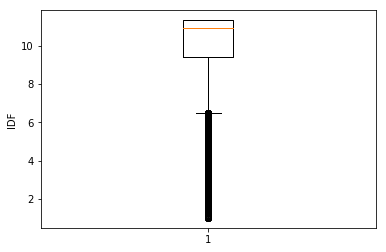

In [12]:
plt.boxplot(tfidf.idf_)
plt.ylabel("IDF")

In [13]:
np.percentile(tfidf.idf_,25)

9.382501942745199

In [14]:
np.percentile(tfidf.idf_,75)

11.328412091800512

In [0]:
feature_idf=dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [0]:
iqr_features=[]


In [0]:
for i,j in feature_idf.items():
    if j>=9.38 and j<=11.32:
        iqr_features.append(i)

In [18]:
len(iqr_features)

17244

In [19]:
len(tfidf.get_feature_names())

48228

In [20]:
from tqdm import tqdm
short_text_train=[]
for i in tqdm(X_train.essay):
    k=' '
    words=i.split()
    for j in words:
        if j in iqr_features:
            k=k+' '+j
    if len(k)>1:
        short_text_train.append(k.strip())
    else:
        short_text_train.append(k)

100%|██████████| 61178/61178 [1:25:45<00:00, 11.89it/s]


In [21]:
short_text_cv=[]
for i in tqdm(X_cv.essay):
    k=' '
    words=i.split()
    for j in words:
        if j in iqr_features:
            k=k+' '+j
    if len(k)>1:
        short_text_cv.append(k.strip())
    else:
        short_text_cv.append(k)

100%|██████████| 15295/15295 [21:29<00:00, 11.43it/s]


In [22]:
short_text_test=[]
for i in tqdm(X_test.essay):
    k=' '
    words=i.split()
    for j in words:
        if j in iqr_features:
            k=k+' '+j
    if len(k)>1:
        short_text_test.append(k.strip())
    else:
        short_text_test.append(k)

100%|██████████| 32775/32775 [45:59<00:00, 11.88it/s]


In [23]:
X_train['short_essay']=short_text_train
X_cv['short_essay']=short_text_cv
X_test['short_essay']=short_text_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Combining Selected_Essay,Project Title, Project Resource summary

In [24]:
X_train['total_text']=X_train['project_title']+' '+X_train['short_essay']+' '+X_train['project_resource_summary']
X_cv['total_text']=X_cv['project_title']+' '+X_cv['short_essay']+' '+X_cv['project_resource_summary']
X_test['total_text']=X_test['project_title']+' '+X_test['short_essay']+' '+X_test['project_resource_summary']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
X_train=X_train[['total_text','school_state','project_grade_category','project_subject_categories','project_subject_subcategories','teacher_prefix','teacher_number_of_previously_posted_projects','presence_of_the_numerical_digits','price','quantity']]
X_cv=X_cv[['total_text','school_state','project_grade_category','project_subject_categories','project_subject_subcategories','teacher_prefix','teacher_number_of_previously_posted_projects','presence_of_the_numerical_digits','price','quantity']]
X_test=X_test[['total_text','school_state','project_grade_category','project_subject_categories','project_subject_subcategories','teacher_prefix','teacher_number_of_previously_posted_projects','presence_of_the_numerical_digits','price','quantity']]

In [29]:
X_train.head(2)

,total_text,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_prefix,teacher_number_of_previously_posted_projects,presence_of_the_numerical_digits,price,quantity
34240,Get Us to the Next Year! My students need th...,al,grades_3_5,appliedlearning_literacy_language,charactereducation_literacy,mrs,9,0,150.82,16
94405,Projecting Pride My students need a replacem...,de,grades_3_5,appliedlearning_history_civics,earlydevelopment_financialliteracy,mrs,15,0,127.39,1


In [28]:
X_train.shape

(61178, 10)

In [0]:
t = Tokenizer()
t.fit_on_texts(X_train.total_text)

In [0]:
len_input1 = len(t.word_index) + 1

In [32]:
len_input1


30388

In [0]:
# Converting Textual Data to Numerical form so we can use this in Embedding Layer
encoded_docs_train = t.texts_to_sequences(X_train.total_text)
encoded_docs_train=np.array(encoded_docs_train)
encoded_docs_train=pad_sequences(encoded_docs_train, maxlen=300, padding='post')

In [0]:
encoded_docs_cv = t.texts_to_sequences(X_cv.total_text)
encoded_docs_cv=np.array(encoded_docs_cv)
encoded_docs_cv=pad_sequences(encoded_docs_cv, maxlen=300, padding='post')

In [0]:
encoded_docs_test = t.texts_to_sequences(X_test.total_text)
encoded_docs_test=np.array(encoded_docs_test)
encoded_docs_test=pad_sequences(encoded_docs_test, maxlen=300, padding='post')

In [36]:
encoded_docs_train.shape

(61178, 300)

In [0]:
link = 'https://drive.google.com/open?id=1jyOxxCTqzM-eKXUc8qxGTZPgqkd-zUKC'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('glove_vectors')  

In [0]:
# Using Pretrained Glove Embedding Model
import pickle
glove = open('glove_vectors', 'rb')      
glove = pickle.load(glove)

In [0]:
embedding_matrix = np.zeros((len_input1, 300))
for word, i in t.word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [42]:
embedding_matrix.shape

(30388, 300)

## School State Feature

In [0]:
school_state_train=X_train.school_state.values

In [0]:
t = Tokenizer()
t.fit_on_texts(school_state_train)

In [0]:
len_input2 = len(t.word_index) + 1

In [46]:
len_input2

52

In [0]:
encoded_school_state_train = t.texts_to_sequences(school_state_train)
encoded_school_state_train=np.array(encoded_school_state_train)
encoded_school_state_train=pad_sequences(encoded_school_state_train, maxlen=1, padding='post')

In [0]:
encoded_school_state_cv = t.texts_to_sequences(X_cv.school_state)
encoded_school_state_cv=np.array(encoded_school_state_cv)
encoded_school_state_cv=pad_sequences(encoded_school_state_cv, maxlen=1, padding='post')

In [0]:
encoded_school_state_test = t.texts_to_sequences(X_test.school_state)
encoded_school_state_test=np.array(encoded_school_state_test)
encoded_school_state_test=pad_sequences(encoded_school_state_test, maxlen=1, padding='post')

## Project Grade Category Feature

In [0]:
school_PGC_train=X_train.project_grade_category.values

In [51]:
t = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
t.fit_on_texts(school_PGC_train)
len_input3 = len(t.word_index) + 1
print(len_input3)

5


In [0]:
encoded_PGC_train = t.texts_to_sequences(school_PGC_train)
encoded_PGC_train=np.array(encoded_PGC_train)
encoded_PGC_train=pad_sequences(encoded_PGC_train, maxlen=1, padding='post')

In [0]:
encoded_PGC_cv = t.texts_to_sequences(X_cv.project_grade_category)
encoded_PGC_cv=np.array(encoded_PGC_cv)
encoded_PGC_cv=pad_sequences(encoded_PGC_cv, maxlen=1, padding='post')

In [0]:
encoded_PGC_test = t.texts_to_sequences(X_test.project_grade_category)
encoded_PGC_test=np.array(encoded_PGC_test)
encoded_PGC_test=pad_sequences(encoded_PGC_test, maxlen=1, padding='post')

## Project Subject Category Feature

In [0]:
school_PSC_train=X_train.project_subject_categories.values

In [56]:
t = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\n')
t.fit_on_texts(school_PSC_train)
len_input4 = len(t.word_index) + 1
print(len_input4)

51


In [0]:
t.word_index

In [0]:
encoded_PSC_train = t.texts_to_sequences(school_PSC_train)
encoded_PSC_train=np.array(encoded_PSC_train)
encoded_PSC_train=pad_sequences(encoded_PSC_train, maxlen=1, padding='post')

In [0]:
encoded_PSC_cv = t.texts_to_sequences(X_cv.project_subject_categories)
encoded_PSC_cv=np.array(encoded_PSC_cv)
encoded_PSC_cv=pad_sequences(encoded_PSC_cv, maxlen=1, padding='post')

In [0]:
encoded_PSC_test = t.texts_to_sequences(X_test.project_subject_categories)
encoded_PSC_test=np.array(encoded_PSC_test)
encoded_PSC_test=pad_sequences(encoded_PSC_test, maxlen=1, padding='post')

## Project Subject SubCategory Feature

In [0]:
school_PSSC_train=X_train.project_subject_subcategories.values

In [62]:
t = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
t.fit_on_texts(school_PSSC_train)
len_input5 = len(t.word_index) + 1
print(len_input5)

386


In [0]:
encoded_PSSC_train = t.texts_to_sequences(school_PSSC_train)
encoded_PSSC_train=np.array(encoded_PSSC_train)
encoded_PSSC_train=pad_sequences(encoded_PSSC_train, maxlen=1, padding='post')

In [0]:
encoded_PSSC_cv = t.texts_to_sequences(X_cv.project_subject_subcategories)
encoded_PSSC_cv=np.array(encoded_PSSC_cv)
encoded_PSSC_cv=pad_sequences(encoded_PSSC_cv, maxlen=1, padding='post')

In [0]:
encoded_PSSC_test = t.texts_to_sequences(X_test.project_subject_subcategories)
encoded_PSSC_test=np.array(encoded_PSSC_test)
encoded_PSSC_test=pad_sequences(encoded_PSSC_test, maxlen=1, padding='post')

## Teacher_prefix Feature

In [0]:
teacher_prefix_train=X_train.teacher_prefix.values

In [67]:
t = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
t.fit_on_texts(teacher_prefix_train)
len_input6 = len(t.word_index) + 1
print(len_input6)

6


In [0]:
encoded_teacher_pre_train = t.texts_to_sequences(teacher_prefix_train)
encoded_teacher_pre_train=np.array(encoded_teacher_pre_train)
encoded_teacher_pre_train=pad_sequences(encoded_teacher_pre_train, maxlen=1, padding='post')

In [0]:
encoded_teacher_pre_cv = t.texts_to_sequences(X_cv.teacher_prefix)
encoded_teacher_pre_cv=np.array(encoded_teacher_pre_cv)
encoded_teacher_pre_cv=pad_sequences(encoded_teacher_pre_cv, maxlen=1, padding='post')

In [0]:
encoded_teacher_pre_test = t.texts_to_sequences(X_test.teacher_prefix)
encoded_teacher_pre_test=np.array(encoded_teacher_pre_test)
encoded_teacher_pre_test=pad_sequences(encoded_teacher_pre_test, maxlen=1, padding='post')

## Numerical Features

In [0]:
X_train_numeric=[]
for i in range(X_train.shape[0]):
    vec=[]
    vec.append(X_train.iloc[i,6])
    vec.append(X_train.iloc[i,7])
    vec.append(X_train.iloc[i,8])
    vec.append(X_train.iloc[i,9])
    X_train_numeric.append(vec)
X_train_numeric=np.array(X_train_numeric)    

In [0]:
X_cv_numeric=[]
for i in range(X_cv.shape[0]):
    vec=[]
    vec.append(X_cv.iloc[i,6])
    vec.append(X_cv.iloc[i,7])
    vec.append(X_cv.iloc[i,8])
    vec.append(X_cv.iloc[i,9])
    X_cv_numeric.append(vec)
    
X_cv_numeric=np.array(X_cv_numeric)

In [0]:
X_test_numeric=[]
for i in range(X_test.shape[0]):
    vec=[]
    vec.append(X_test.iloc[i,6])
    vec.append(X_test.iloc[i,7])
    vec.append(X_test.iloc[i,8])
    vec.append(X_test.iloc[i,9])
    X_test_numeric.append(vec)
X_test_numeric=np.array(X_test_numeric)

## Model

In [0]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true,y_pred):
    return tf.py_func(roc_auc_score,(y_true,y_pred),tf.double)

In [81]:
!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://dda1d724.ngrok.io


In [82]:
from keras.layers import SpatialDropout1D
from keras.callbacks import TensorBoard
input1 = Input(shape=(300,))
x1 = Embedding(len_input1, 300, weights=[embedding_matrix], trainable=False)(input1)
x1=SpatialDropout1D(0.3)(x1)
x1 = LSTM(140,return_sequences=True)(x1)
x1 = Flatten()(x1)

input2=Input(shape=(1,))
x2=Embedding(input_dim=len_input2,output_dim= 2)(input2)
x2=Flatten()(x2)

input3=Input(shape=(1,))
x3=Embedding(input_dim=len_input3,output_dim= 2)(input3)
x3= Flatten()(x3)

input4=Input(shape=(1,))
x4=Embedding(input_dim=len_input4,output_dim= 2)(input4)
x4=Flatten()(x4)

input5=Input(shape=(1,))
x5=Embedding(input_dim=len_input5,output_dim= 10)(input5)
x5=Flatten()(x5)

input6=Input(shape=(1,))
x6=Embedding(input_dim=len_input6,output_dim= 5)(input6)
x6=Flatten()(x6)

input7=Input(shape=(4,))
x7=Dense(40,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))(input7)

concat=concatenate([x1,x2,x3,x4,x5,x6,x7])

x=Dense(128,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))(concat)
x=Dropout(0.5)(x)
x=Dense(64,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))(x)
x=Dropout(0.5)(x)
x=BatchNormalization()(x)
x=Dense(32,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))(x)
x=Dropout(0.5)(x)
output=Dense(2, activation='softmax')(x)


model=Model([input1,input2,input3,input4,input5,input6,input7], output)


tensorboard=TensorBoard(log_dir="logs")

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=[auroc])

print(model.summary())



Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 300, 300)     9116400     input_8[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 300, 300)     0           embedding_7[0][0]                
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 1)            0                                            
____________________________________________________________________________________________

In [83]:
#keras.backend.get_session().run(tf.global_variables_initializer())
model.fit([encoded_docs_train,encoded_school_state_train,encoded_PGC_train,encoded_PSC_train,encoded_PSSC_train,
           encoded_teacher_pre_train,X_train_numeric], y_train, epochs=35,verbose=1,batch_size=256,class_weight='balanced',
          validation_data=([encoded_docs_cv,encoded_school_state_cv,encoded_PGC_cv,encoded_PSC_cv,encoded_PSSC_cv,
           encoded_teacher_pre_cv,X_cv_numeric]  , y_cv),callbacks=[TensorBoardColabCallback(tbc)] )

Train on 61178 samples, validate on 15295 samples
Epoch 1/35
61178/61178 [==============================] - 152s 2ms/step - loss: 0.6097 - auroc: 0.5039 - val_loss: 0.4852 - val_auroc: 0.5798
Epoch 2/35
61178/61178 [==============================] - 151s 2ms/step - loss: 0.4802 - auroc: 0.5308 - val_loss: 0.4513 - val_auroc: 0.5914
Epoch 3/35
61178/61178 [==============================] - 151s 2ms/step - loss: 0.4534 - auroc: 0.5486 - val_loss: 0.4417 - val_auroc: 0.5941
Epoch 4/35
61178/61178 [==============================] - 150s 2ms/step - loss: 0.4443 - auroc: 0.5568 - val_loss: 0.4339 - val_auroc: 0.6013
Epoch 5/35
61178/61178 [==============================] - 152s 2ms/step - loss: 0.4434 - auroc: 0.5559 - val_loss: 0.4354 - val_auroc: 0.5933
Epoch 6/35
61178/61178 [==============================] - 150s 2ms/step - loss: 0.4372 - auroc: 0.5730 - val_loss: 0.4327 - val_auroc: 0.6033
Epoch 7/35
61178/61178 [==============================] - 151s 2ms/step - loss: 0.4339 - auroc: 0.

In [0]:
pred=model.predict([encoded_docs_test,encoded_school_state_test,encoded_PGC_test,encoded_PSC_test,encoded_PSSC_test,
           encoded_teacher_pre_test,X_test_numeric])

In [85]:
roc_auc_score(y_test,pred)

0.7006759103370985

### Loss with Epochs [Training:Orange, Validation:Blue]

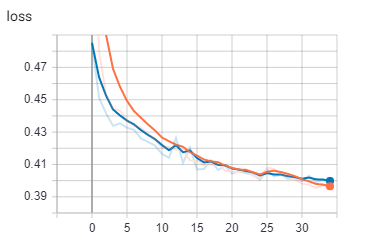

In [1]:
from IPython.display import Image
Image(filename='model2_loss.png')

#### As we can see training and validation loss are very close so there is no overfitting and our model is fine

### AUC with Epochs [Training:Orange, Validation:Blue]

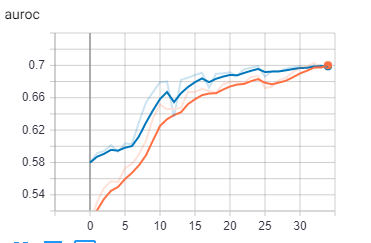

In [2]:
from IPython.display import Image
Image(filename='model2_auc.png')

# Conclusion

* We have used the same approach as Model 1 just 1 change as in this model we created a new short_essay feature from essay feature by using top words from there IDF values 
* First Input will be passed to a LSTM Layer 
* Seventh input will be passed to a densu relu activated layer
* And all other inputs are passed to embedding layer for trainig 
* We have used L2 regularizer to prevent our model from overfitting 
* we have used adam optimizer
* After 35 Epochs:
    Training Loss-0.3950
    Validation Loss-0.3985
    Training AUC-0.7044 
    Validation AUC-0.6984
* Testing AUC of this Model is 0.7006